# Spanish Etymology Scraper

## UTF-8 encoding, imports, and constants

In [6]:
# -*- coding: utf-8 -*-
%matplotlib inline

import os.path
import re
import time

from bs4 import BeautifulSoup
from urllib2 import quote
import matplotlib.pyplot as plt
import pickle
import requests

# ------------------------------------------------------------------------------
# When DEBUGGING = True, program will print more info and load only first 25
# words. (Note: zer-indexed word number 22, i.e. 'más', is the first one with a
# non-ascii character, it's important to include it when debugging string
# encodings).
DEBUGGING = True
NUM_WORDS_IN_DEBUG_MODE = 50 # originally 25

# Directory holding unigram count files.
UNIGRAM_COUNTS_DIR = 'unigram_counts/'
# 1000 most common CREA corpus unigrams, 36KB.
UNIGRAM_COUNTS_FILENAME_SMALL = '1000_formas.txt'
# 5000 most common CREA corpus unigrams, 188KB.
UNIGRAM_COUNTS_FILENAME_MEDIUM = '5000_formas.txt'
# 10000 most common CREA corpus unigrams, 379KB.
UNIGRAM_COUNTS_FILENAME_LARGE = '10000_formas.txt'
# All 737799 CREA corpus unigrams, 29MB.
UNIGRAM_COUNTS_FILENAME_EXTRA_LARGE = 'CREA_total.txt'

HTML_RESPONSES_LIST_CACHE_FILENAME = 'html_responses_list_cache.pkl'

ARTICLE_HTML_TAG_REGEX = re.compile('<article')
DICTIONARY_ENTRY_ID_CAPTURE_REGEX = re.compile('"fetch\?id=(.*?)"')

SPANISH_ETYMOLOGY_REGEX = re.compile(ur'<abbr title="Apócope">Apóc.</abbr>' +
                                     ur'|<abbr title="antiguo">ant.</abbr>')
LATIN_ETYMOLOGY_REGEX = re.compile(ur'<abbr title="latín">lat.</abbr>')
GREEK_ETYMOLOGY_REGEX = re.compile(ur'<abbr title="griego">gr.</abbr>')

LANGUAGE_ETYMOLOGY_REGEXES = [
    ('SPANISH', SPANISH_ETYMOLOGY_REGEX),
    ('Latin', LATIN_ETYMOLOGY_REGEX),
    ('GREEK', GREEK_ETYMOLOGY_REGEX),
    ]

FULL_UNIGRAM_COUNTS_FILENAME = \
    UNIGRAM_COUNTS_DIR + UNIGRAM_COUNTS_FILENAME_MEDIUM

## Auxiliary Functions

In [7]:
def parse_unigrams_and_frequencies(full_unigram_counts_filename):
    """
    Parses unigram counts from CREA corpus count file and returns a list of
    words and a list of their corresponding frequencies.
    """
    #counts_dict = {}
    word_list = []
    frequency_list = []
    with open(full_unigram_counts_filename, 'r') as f:
        for line_number, line in enumerate(f):
            if line_number is 0 or line.isspace() or not line:
                continue
            if DEBUGGING and line_number is (NUM_WORDS_IN_DEBUG_MODE+1):
                break
            #print(line)
            _, word, freq_count_str, _ = line.split()
            freq_count = int(freq_count_str.replace(',', ''))
            # Unigram files are encoded in latin-1. Decode them.
            decoded_word = word.decode('latin1').encode('utf-8')
            #print(decoded_word + ' ' + freq_count_str)
            #counts_dict[decoded_word] = freq_count
            word_list.append(decoded_word)
            frequency_list.append(freq_count)
    #return counts_dict
    return word_list, frequency_list

def plot_frequencies_and_zipfs_law(word_list,
                                   frequency_list,
                                   min_rank=1):
    if len(frequency_list) > min_rank:
        plot_range = range(min_rank, len(frequency_list)+1)
        plt.plot(plot_range,
                 frequency_list[min_rank-1:],
                 '-',
                 label='counts')
        plt.plot(plot_range,
                 [frequency_list[0]/x for x in plot_range],
                 '-',
                 label='(frequency of word #1)/(word rank)')
        plt.legend()
        plt.title('Word Frequency Decay')
        plt.ylabel('Frequency')
        plt.xlabel('Word frequency rank (Words ranked '
                   + str(min_rank)
                   + ' or less frequent)')
        plt.show()

def generate_dictionary_lookup_url(word=None, search_type='by_word'):
    """
    possible search types: 'by_word', 'exact_match', 'begins_with', 'ends_with',
    'contains', or 'random'
    - 'by_word' matches the searched term, or any verb that conjugates to the
      search term
    - 'random' ignores the word and gets a URL for a random word.
    - The rest of the search types are self-explanatory
    """
    base_url = 'http://dle.rae.es/srv/'
    
    if search_type is 'random':
        # Make sure search term is undefined.
        if word:
            raise
        return base_url + 'random'
    
    # Make sure search term is defined.
    if word is None:
        raise

    if search_type is 'by_word':
        return base_url + 'search?w=' + quote(word) + '&m=form'
    elif search_type is 'exact_match':
        return base_url + 'search?w=' + quote(word) + '&m=30'
    elif search_type is 'begins_with':
        return base_url + 'search?w=' + quote(word) + '&m=31'
    elif search_type is 'ends_with':
        return base_url + 'search?w=' + quote(word) + '&m=32'
    elif search_type is 'contains':
        return base_url + 'search?w=' + quote(word) + '&m=33'
    else:
        raise

def generate_dictionary_entry_url(entry_id):
    return 'http://dle.rae.es/srv/fetch?id=' + entry_id

def scrape_definition_html_responses(word):
    print(word)
    # Get lookup URL.
    url = generate_dictionary_lookup_url(word=word, search_type='exact_match')
    print(url)
    # Retrieve HTML.
    r  = requests.get(url)
    html_response = r.text
    if ARTICLE_HTML_TAG_REGEX.search(html_response):
        # Redirected to definition page. Save HTML directly.
        
        print('Redirected to definition page')
        return [html_response]
    else:
        # Showing listing of many entries. Need to follow links.
        
        html_responses = []
        for entry_id in DICTIONARY_ENTRY_ID_CAPTURE_REGEX.finditer(html_response):
            url = generate_dictionary_entry_url(entry_id=entry_id.group(1))
            r  = requests.get(url)
            html_response = r.text
            html_responses.append(html_response)
        return html_responses
    # Rate limiting for respect towards RAE.
    time.sleep(0.8 + 0.4*random.random())

def get_definition_html_responses(word_list):
    _html_responses_list = []
    if os.path.isfile(HTML_RESPONSES_LIST_CACHE_FILENAME):
        # Load cache file.

        print('Cache file found. Loading it now.')

        pkl_file = open(HTML_RESPONSES_LIST_CACHE_FILENAME, 'rb')
        _html_responses_list = pickle.load(pkl_file)
        print(len(_html_responses_list))

    if len(_html_responses_list) < len(word_list):
        # Cache file is incomplete. Scrape the missing items and cache them.

        print('Scraping new definitions.')

        start_word_index = len(_html_responses_list)
        for i in xrange(start_word_index, len(word_list)):
            _html_responses_list.append(scrape_definition_html_responses(word=word_list[i]))

        # Open cache file in overwrite mode.
        outfile = open(HTML_RESPONSES_LIST_CACHE_FILENAME, 'wb')
        # Save cache to cache file.
        pickle.dump(_html_responses_list, outfile)
        print('Saving Cache File.')
        outfile.close()
    return _html_responses_list

## Get list of words to look up, and plot their frequency

DEBUGGING?: True
Number of words loaded: 50
Max Frequency: 9999518
Min Frequency: 194168
Word ranked #23 (It should be 'más'): más

Top 25 words and their frequencies:
[('de', 9999518), ('la', 6277560), ('que', 4681839), ('el', 4569652), ('en', 4234281), ('y', 4180279), ('a', 3260939), ('los', 2618657), ('se', 2022514), ('del', 1857225), ('las', 1686741), ('un', 1659827), ('por', 1561904), ('con', 1481607), ('no', 1465503), ('una', 1347603), ('su', 1103617), ('para', 1062152), ('es', 1019669), ('al', 951054), ('lo', 866955), ('como', 773465), ('m\xc3\xa1s', 661696), ('o', 542284), ('pero', 450512), ('sus', 449870), ('le', 413241), ('ha', 380339), ('me', 374368), ('si', 327480), ('sin', 298383), ('sobre', 289704), ('este', 285461), ('ya', 274177), ('entre', 267493), ('cuando', 257272), ('todo', 247340), ('esta', 238841), ('ser', 232924), ('son', 232415), ('dos', 228439), ('tambi\xc3\xa9n', 227411), ('fue', 223791), ('hab\xc3\xada', 223430), ('era', 219933), ('muy', 208540), ('a\xc3\xb1o

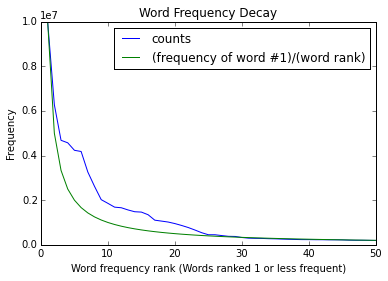

In [10]:
word_list, frequency_list = parse_unigrams_and_frequencies(FULL_UNIGRAM_COUNTS_FILENAME)

print('DEBUGGING?: ' + str(DEBUGGING))
print('Number of words loaded: ' + str(len(word_list)))
print('Max Frequency: ' + str(frequency_list[0]))
print('Min Frequency: ' + str(frequency_list[-1]))
print('Word ranked #23 (It should be \'más\'): ' + word_list[22])

print('')

print('Top 25 words and their frequencies:')
print(zip(word_list[:50], frequency_list[:50]))

print('')

print('The word counts approximate Zipf\'s law')
for min_rank in [1, 50, 100]:
    plot_frequencies_and_zipfs_law(word_list=word_list,
                                   frequency_list=frequency_list,
                                   min_rank=min_rank)

## Get definitions from cache (or scrape and cache if not cached yet)

In [9]:
html_responses_list = get_definition_html_responses(word_list=word_list)

Cache file found. Loading it now.
50


## Scraping Loop

In [12]:
# Main loop
for i, html_responses in enumerate(html_responses_list):
    if len(html_responses) == 0:
        print('WARNING: no definitions found for word "' + word_list[i] + '"')
        continue
    for html_response in html_responses:
        soup = BeautifulSoup(html_response, "lxml")
        # print(soup.header)
        etymology_strings = soup.find_all(class_='n2')
        # print(etymology_strings)
        for etymology_string in etymology_strings:
            num_origins = 0
            for (language_name, language_etymology_regex) in LANGUAGE_ETYMOLOGY_REGEXES:
                if language_etymology_regex.search(unicode(etymology_string)):
                    print('Word "' + word_list[i] + '" comes from ' + language_name)
                    num_origins = num_origins + 1
            if num_origins == 0:
                print(word_list[i] + ": " + unicode(etymology_string))

Word "de" comes from Latin
la: <p class="n2"><i><abbr title="Confer">Cf.</abbr></i> <em>fa.</em></p>
Word "la" comes from Latin
Word "que" comes from Latin
Word "el" comes from Latin
Word "en" comes from Latin
Word "y" comes from Latin
Word "y" comes from Latin
Word "a" comes from Latin
Word "se" comes from Latin
Word "se" comes from SPANISH
Word "se" comes from Latin
Word "por" comes from Latin
Word "con" comes from Latin
Word "no" comes from Latin
Word "una" comes from Latin
una: <p class="n2">De <em>uno</em><sup>1</sup>.</p>
Word "su" comes from SPANISH
Word "para" comes from SPANISH
Word "lo" comes from Latin
Word "como" comes from GREEK
Word "como" comes from Latin
Word "más" comes from SPANISH
Word "más" comes from Latin
Word "o" comes from Latin
Word "o" comes from Latin
Word "pero" comes from Latin
pero: <p class="n2">De <em>Pedro.</em></p>
Word "pero" comes from Latin
sus: <p class="n2">De <em>suso.</em></p>
Word "le" comes from Latin
Word "me" comes from Latin
Word "si" comes

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 5: ordinal not in range(128)

## Scraping

**Some things to consider before scraping.**

Strange examples:
- Word definition is just a link to a variant: e.g. 'oósfera' (http://dle.rae.es/?id=R5P5ZTh) This only occurs during 'exact_match' search. 'by_word' search automatically redirects to the other word.
- Definition header shows word variant: http://dle.rae.es/?id=R5OqL2A
- Word not found
- Several words found even with 'exact_match': e.g. 'si' http://dle.rae.es/srv/search?w=si&m=30